# CSCI 5622
## Homework 4: Designing ML Models for Real-World Problems
### Team 5 - Study 2
##### Cassie Sterns, Saksham Khatwani, Jasdeep Singh, and Nirmit Karkera

In [2]:
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re

In [3]:
# Reading in data
prosodic_file = "prosodic_features.csv"
scores_file = "scores.csv"
transcript_file = "transcripts.csv"

# Read csvs into a file
prosodic_data = pd.read_csv(prosodic_file)
scores_data = pd.read_csv(scores_file)
transcript_data = pd.read_csv(transcript_file)

# Add a column that corresponds to participant for easy splitting for prosodic data
prosodic_data['Participant'] = prosodic_data['participant&question'].str.extract(r'^(PP?\d+)')
prosodic_data['Participant'] = prosodic_data['Participant'].str.lower()
# Make the entire transcript lower case
transcript_data['Transcript'] = transcript_data['Transcript'].str.lower()


In [4]:
# Splitting the participants into 5 folds
num_folds = 5

# Grab participant numbers from the scores csv file
interviews = scores_data['Participant'].unique()
participants = list(set([re.sub(r'^pp?|q\d+', '', item) for item in interviews]))
random.shuffle(participants)
participant_folds = [participants[i::num_folds] for i in range(num_folds)]

for i, fold in enumerate(participant_folds):
  print(f"Fold {i + 1}: {fold}")
  print("\tLength: ", len(fold))

# Grab all the correct interview names associated with each participant
interview_folds = []
for fold in participant_folds:
  interview_folds.append([item for num in fold for item in (f"p{num}", f"pp{num}")])


Fold 1: ['83', '70', '72', '16', '63', '71', '5', '85', '34', '59', '3', '67', '33', '12']
	Length:  14
Fold 2: ['76', '21', '11', '17', '32', '56', '89', '80', '14', '65', '24', '42', '31', '29']
	Length:  14
Fold 3: ['77', '6', '52', '1', '35', '81', '47', '27', '49', '61', '55', '22', '30', '10']
	Length:  14
Fold 4: ['62', '8', '73', '53', '84', '37', '13', '69', '64', '4', '78', '48', '43', '86']
	Length:  14
Fold 5: ['15', '57', '7', '45', '60', '20', '44', '79', '58', '50', '74', '66', '25']
	Length:  13


In [5]:
def get_data_splits(data, fold_number):
    """
    Split data into training, validation, and testing sets based on a specified fold.
    
    Parameters:
        data (DataFrame): The complete dataset.
        fold_number (int): The fold to use for testing (0-based index).
        
    Returns:
        tuple: (training_set, validation_set, testing_set)
    """
    # Quick check on fold number
    assert 0 <= fold_number < len(interview_folds), "Fold_number must be between 0 and len(folds) - 1"

    # Split the data
    test_set = data[data['Participant'].isin( interview_folds[fold_number] )]
    val_set = data[data['Participant'].isin( interview_folds[(fold_number + 1) % len(interview_folds)] )]
    train_set_parts = [item for i, fold in enumerate(interview_folds) if i not in [fold_number, (fold_number + 1) % len(interview_folds)] for item in fold]
    train_set = data[data['Participant'].isin(train_set_parts)]
    
    return train_set, val_set, test_set


In [6]:
train_set, val_set, test_set = get_data_splits(prosodic_data, 0)
# print("Prosodic Data: ")
# train_set.head()
train_set, val_set, test_set = get_data_splits(scores_data, 0)
# print("Scores Data: ")
# test_set.head()
train_set, val_set, test_set = get_data_splits(transcript_data, 0)
# print("Transcript Data: ")
# test_set.head()

# (a) Extracting language features

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from transformers import BertTokenizer, BertModel

nltk.download('punkt_tab')  # Tokenizer
nltk.download('averaged_perceptron_tagger_eng')  # POS Tagger
nltk.download('vader_lexicon') # Vader

/Users/jasdeepsingh/tensorflow_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jasdeepsingh/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/jasdeepsingh/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jasdeepsingh/nltk_data...


True

### Syntactic Vectorization with CountVectorizer

In [20]:
# Syntactic vectorizer: CountVectorizer

# Remove common stop words in english and ignore words that appear fewer than 2 times
vectorizer = CountVectorizer(stop_words='english', min_df=2) 
X = vectorizer.fit_transform(transcript_data['Transcript'])

# Convert from sparse X matrix to a denser one for easy use
X_dense = X.toarray()
feature_names_count = vectorizer.get_feature_names_out()

word_count = pd.DataFrame(X_dense, columns=feature_names_count)

word_count.head()

,000,10,100,13,14,15,16,18,20,200,...,yep,yes,yo,yoga,york,young,younger,youngest,yup,zone
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Syntactic Vectorization with TFIDF Vectorizer

In [21]:
# Syntactic vectorizer: TFIDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', min_df=2)
tfidf_matrix = tfidf.fit_transform(transcript_data['Transcript'])
feature_names_tf = tfidf.get_feature_names_out()
tfidf_count = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names_tf)

tfidf_count.head()

,000,10,100,13,14,15,16,18,20,200,...,yep,yes,yo,yoga,york,young,younger,youngest,yup,zone
0,0.068513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.031465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Statistical Features (word count and average word length)

In [22]:
# Statistical Features (word count and average word length)

# Word Count for the entire interview
features = pd.DataFrame()
features['word count'] = transcript_data['Transcript'].apply(lambda x: len(x.split()))

# Average word length for the interview
features['avg word length'] = transcript_data['Transcript'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

features.head()

,word count,avg word length
0,613,4.438825
1,1118,4.510733
2,751,4.528628
3,717,4.281729
4,645,4.688372


### Part of Speech Tagging

In [23]:
# Part of Speech Tagging using NLTK

features['pos tagging'] = transcript_data['Transcript'].apply(lambda x: pos_tag(word_tokenize(x)))

features['pos tagging'].head()
# NN: Noun singular
# VB: Verb base form
# JJ: Adjective
# RB: Adverb
# DT: Determiner
# IN: Preposition or subordination conjunction

0    [(interviewer, NN), (:, :), (so, RB), (how, WR...
1    [(interviewer, NN), (:, :), (so, RB), (how, WR...
2    [(interviewer, NN), (:, :), (so, RB), (tell, V...
3    [(interviewer, NN), (:, :), (so, RB), (how, WR...
4    [(interviewer, NN), (:, :), (how, WRB), (are, ...
Name: pos tagging, dtype: object

### Sentiment Analysis with Vader

In [24]:
# Sentiment Analysis with Vader
analyzer = SentimentIntensityAnalyzer()
features['sentiment'] = transcript_data['Transcript'].apply(lambda x: analyzer.polarity_scores(x))

features['sentiment'].head()

0    {'neg': 0.013, 'neu': 0.859, 'pos': 0.128, 'co...
1    {'neg': 0.026, 'neu': 0.852, 'pos': 0.122, 'co...
2    {'neg': 0.02, 'neu': 0.874, 'pos': 0.105, 'com...
3    {'neg': 0.027, 'neu': 0.842, 'pos': 0.131, 'co...
4    {'neg': 0.038, 'neu': 0.838, 'pos': 0.124, 'co...
Name: sentiment, dtype: object

### Word Embeddings with BERT

In [28]:
# Word embeddings with BERT (Hugging Face)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [29]:
# Separate interveiw into sentences
def process_transcript(text):
  sentences = re.split(r'(?<=\|)', text)
  cleaned_sentences = [
    re.sub(r'^(interviewer:|interviewee:)\s*', '', s.strip().replace('|', '')) for s in sentences if s.strip()
  ]
  return cleaned_sentences

transcript_data['Processed Transcript'] = transcript_data['Transcript'].apply(process_transcript)

# Tokenize the text
def get_bert_embeddings(sentences):
  embeddings = []
  for sentence in sentences:
    # Tokenize and get input Id and attention mask
    inputs = tokenizer(sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=20)

    # Use BERT
    with torch.no_grad():
      outputs = model(**inputs)

    # Pool output
    cls_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings.append(cls_embedding)

  # Return an array that is the same size
  return np.array(embeddings).flatten()[:6912]

features['word embeddings'] = transcript_data['Processed Transcript'].apply(get_bert_embeddings)

features['word embeddings'].head()

0    [0.20702145, -0.34244877, 0.10633576, 0.048458...
1    [0.203389, -0.42223397, -0.0042751534, -0.0004...
2    [0.3116176, -0.17067054, -0.09439892, 0.182088...
3    [0.21430016, -0.47013935, -0.070550025, 0.1250...
4    [0.1723062, -0.37611648, -0.10042636, -0.02611...
Name: word embeddings, dtype: object

### Language Features Extracted: 
- Syntactic Vectorization with CountVectorizer 
- Syntactic Vectorization with TFIDF Vectorizer
- Word Count
- Average Word Length
- Part of Speech Tagging
- Sentiment Analysis with Vader
- Word Embedding with BERT

A total of 7 distinctive features. 

The human readable features are: CountVectorizer because it is a count of the words throughout the interview, the Statistical Features, Part of Speech Tagging (with a little extra interpretation), and Sentiment Analysis with Vader.

# (b) Language feature selection

In [30]:
import scipy.stats as stats

For this section, we used 2 different filter feature selection methods to try to understand the data better. The first method we use is the pearsonr correlation, which we used to compare word count, average word length, word frequency, and sentiment analysis. Then we used mutual information to compare all of the features we extracted. Mutual information was used because it is good at handling both low-dimensionality (eg Word Count) and high dimensionality (eg BERT embeddings) features and captures non-linear relationships between features and target variables.

### Pearson Correlation

In [31]:
# Find correlation for the n (number) most impactful words from the word_count CountVectorizer
def find_top_words(number):
  overall_accumulator = []
  excited_accumulator = []
  for word in word_count.columns:
    corr, _ = stats.pearsonr(word_count[word], scores_data["Overall"])
    overall_accumulator.append({"Word": word, "Correlation": corr})
    corr, _ = stats.pearsonr(word_count[word], scores_data["Excited"])
    excited_accumulator.append({"Word": word, "Correlation": corr})

  overall_corr = pd.DataFrame(overall_accumulator)
  excited_corr = pd.DataFrame(excited_accumulator)

  overall_corr["Abs Correlation"] = overall_corr["Correlation"].abs()
  excited_corr["Abs Correlation"] = excited_corr["Correlation"].abs()

  top_10_overall = overall_corr.nlargest(number, 'Abs Correlation')
  top_10_excited = excited_corr.nlargest(number, 'Abs Correlation')

  return [top_10_overall, top_10_excited]

In [32]:
# Using correlation to compare: word count, average word length, word frequency, and sentiment analysis

feature_cols = ["word count", "avg word length"]
outcome_cols = ["Overall", "Excited"]

Overall_correlation = []
Excited_correlation = []

for feature in feature_cols:
  corr, _ = stats.pearsonr(features[feature], scores_data["Overall"])
  Overall_correlation.append({"Feature": feature, "Correlation": corr})
  corr, _ = stats.pearsonr(features[feature], scores_data["Excited"])
  Excited_correlation.append({"Feature": feature, "Correlation": corr})

# Find correlation for the most impactful words from the word_count CountVectorizer
top_overall, top_excited = find_top_words(20)

for _, row in top_overall.iterrows():
  Overall_correlation.append({"Feature": f"word - {row['Word']}", "Correlation": row['Correlation']})

for _, row in top_excited.iterrows():
  Excited_correlation.append({"Feature": f"word - {row['Word']}", "Correlation": row['Correlation']})

# Find correlation for the sentiment analysis
# Expand sentiment column into its own dictionary
sentiment_df = features["sentiment"].apply(pd.Series)
for feature in ['neg', 'neu', 'pos', 'compound']:
  corr, _ = stats.pearsonr(sentiment_df[feature], scores_data["Overall"])
  Overall_correlation.append({"Feature": f"sentiment - {feature}", "Correlation": corr})
  corr, _ = stats.pearsonr(sentiment_df[feature], scores_data["Excited"])
  Excited_correlation.append({"Feature": f"sentiment - {feature}", "Correlation": corr})

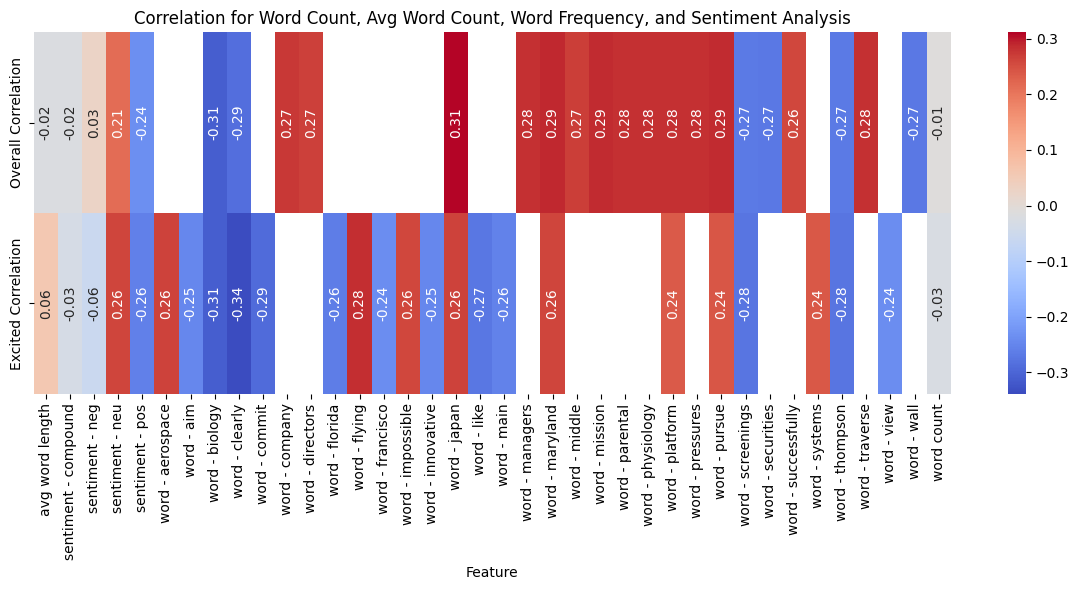

In [33]:
overall_corr_df = pd.DataFrame(Overall_correlation)
overall_corr_df = overall_corr_df.rename(columns={'Correlation': 'Overall Correlation'})
excited_corr_df = pd.DataFrame(Excited_correlation)
excited_corr_df = excited_corr_df.rename(columns={'Correlation': 'Excited Correlation'})
merged_df = pd.merge(overall_corr_df, excited_corr_df, how="outer", on="Feature")
correlation_matrix = merged_df.set_index('Feature').T 

fig, axes = plt.subplots(1, 1, figsize=(12,6))

#Plot overall correlation
ax = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
for t in ax.texts: t.set_rotation(90)
axes.set_title('Correlation for Word Count, Avg Word Count, Word Frequency, and Sentiment Analysis')

plt.tight_layout()
plt.show()

From the correlation, we can see that for the Overall outcome, the strongest positive correlations are: the words japan, maryland, managers, mission, parental, physiology, platform, pressures, and traverse. It is important to note here that the neu sentiment has a 0.21 correlation with the Overall Outcome as well. The strongest negative correlations for the Overall outcome are: pos sentiment (interestingly) and the words biology, clearly, screenings, securities, thompson, and wall. Looking at this, it is pretty clear that although word frequency can be helpful in finding patterns, it is rather random and not the most reliable source of performance on an interview.

For the Excited outcome, the strongest positive correlations are: neu sentiment and the words aerospace, flying, impossible, japan, and maryland. The strongest negative correlations were: pos sentiment (also interesting to note) and the words clearly, biology, screenings, commit, and thompson. These results should again be used with caution as singular words like japan and maryland (probably) don't have anything to do with the performance of the interviewee. 

Overall, the statistical (and simple) features of word count and average word length didn't correlate well to either outcome and shouldn't be used. The same could be said about neg sentiment and compuond sentiment. Using neu sentiment and pos sentiment has a decent amount of relevance to the two considered outcomes, and so do a lot of words. The individual words should be used with caution in determining the relevance of those words to the final outcome.

### Mutual Information

In [38]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

In [39]:
np.vstack(features['word embeddings'].values).shape


(138, 6912)

In [40]:
# Use Mutual Information as a filter feature selection method
def get_top_10(X, feature_names):
    for outcome in ["Overall", "Excited"]:
        # Overall target
        y = scores_data[outcome]

        # Use mutual_info_regression for continuous target variable
        mi = mutual_info_regression(X, y)
        correlations = [stats.pearsonr(X[:, i], y)[0] for i in range(X.shape[1])]

        # Convert to a DataFrame to view the features and their MI scores
        mi_df = pd.DataFrame({
            'Feature': feature_names,
            'MI Score': mi,
            'Correlation': correlations
        })

        # Sort by MI score to find the most relevant features
        top_mi_df = mi_df.sort_values(by='MI Score', ascending=False).head(10)

        mi_df['Abs Correlation'] = mi_df['Correlation'].abs()
        top_corr_df = mi_df.sort_values(by='Abs Correlation', ascending=False).head(10)
        top_corr_df = top_corr_df.drop(columns=['Abs Correlation'])
        # Display the top features with high MI score
        print("\nTop 10 mi features for: ", outcome)
        display_corr_graphs(top_mi_df)
        # print(mi_df.head(10))
        print("\nTop 10 correlation features for: ", outcome)
        display_corr_graphs(top_corr_df)
        # print(corr_df.head(10))

def display_corr_graphs(data):
    # This function is for plotting the correlation graphs easily

    # Preprocess the data
    correlations = data.set_index('Feature').T

    # Make the figure
    plt.figure(figsize=(12,6))
    ax = sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    for t in ax.texts: t.set_rotation(90)
    plt.tight_layout()
    plt.show()



Top 10 mi features for:  Overall


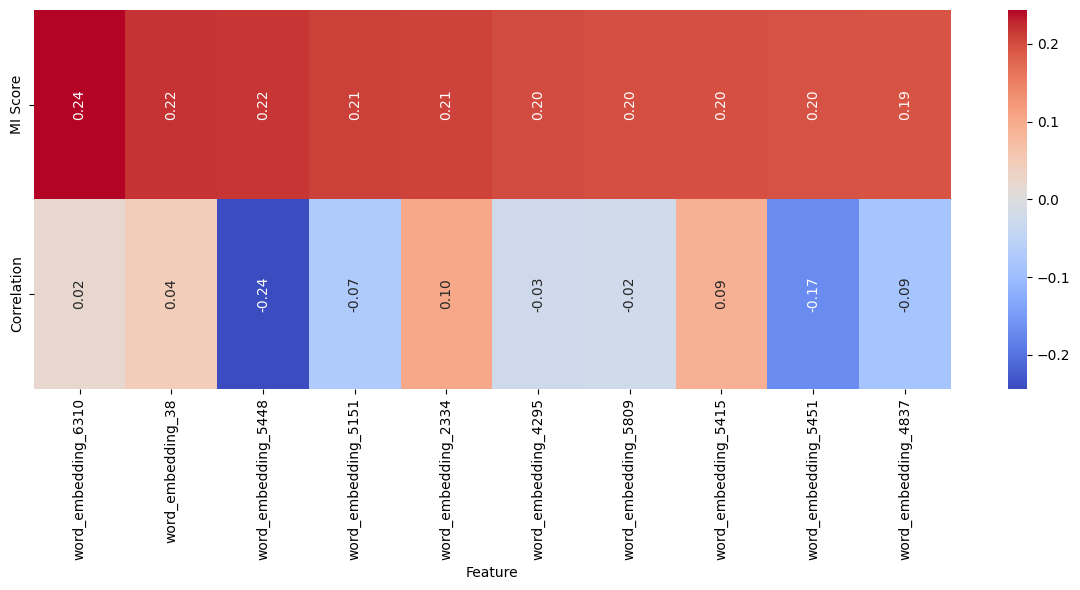


Top 10 correlation features for:  Overall


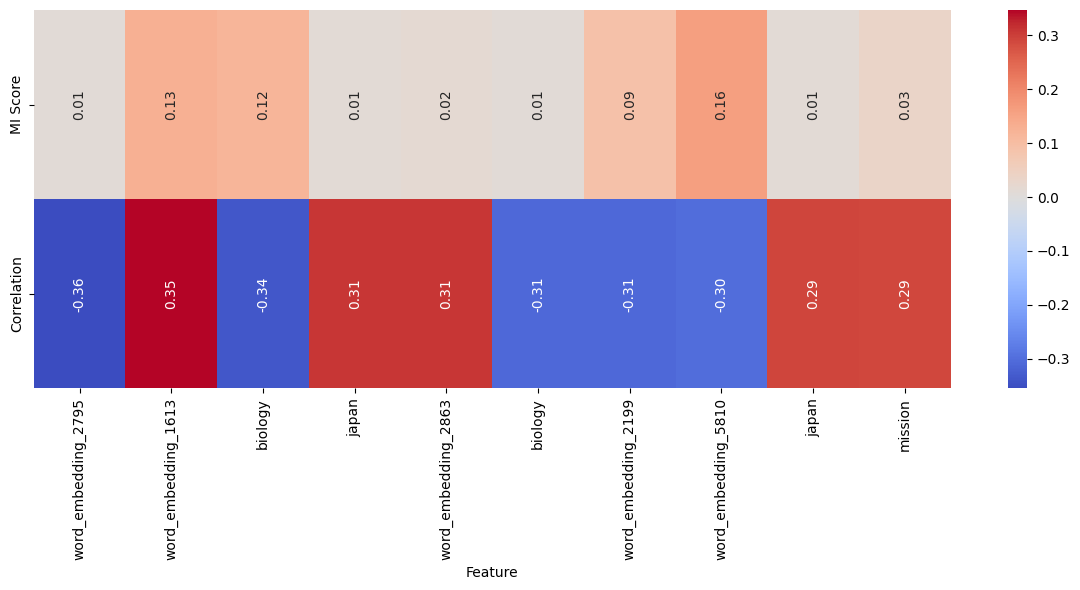


Top 10 mi features for:  Excited


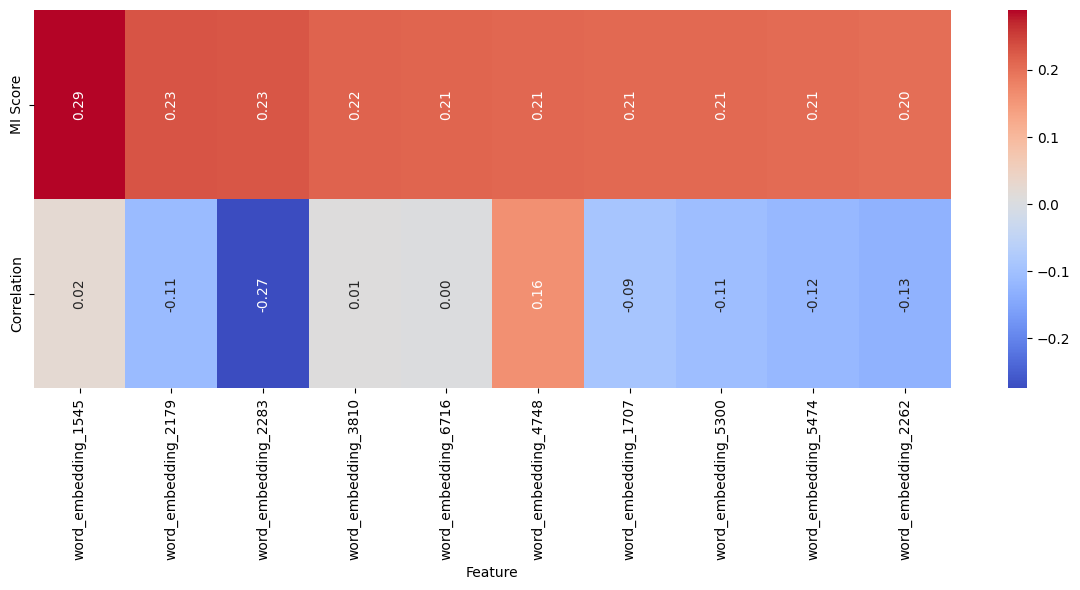


Top 10 correlation features for:  Excited


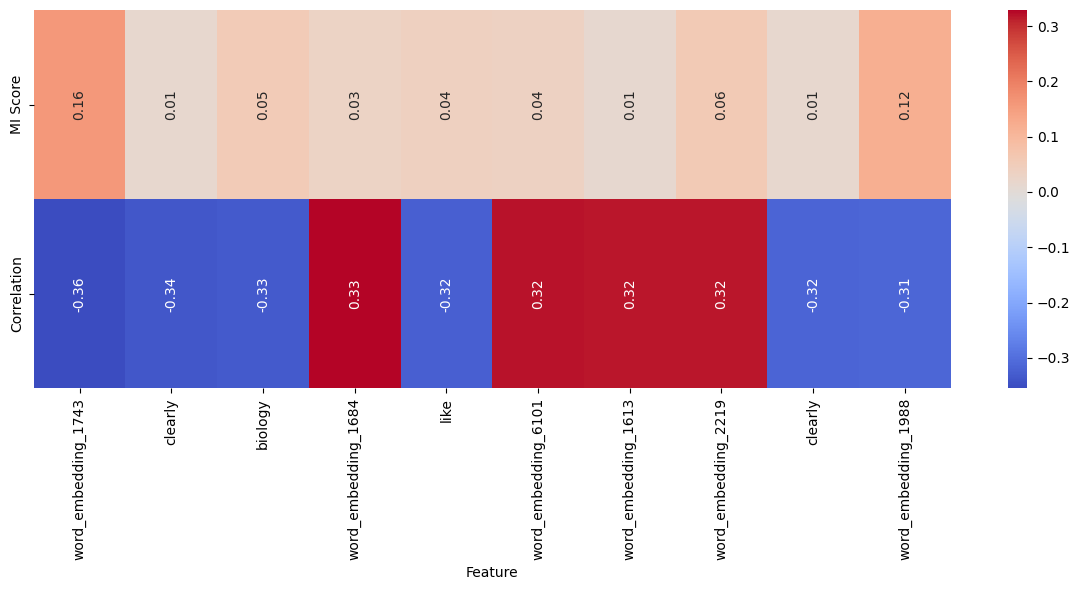

In [42]:
# Find the top 10 contributing features to the results for both Overall and Excited

word_emb_features = np.vstack(features['word embeddings'].values)
# Combine all features in to a single matrix X
X = np.hstack([X_dense, tfidf_matrix.toarray(), 
    features['word count'].values.reshape(-1, 1),
    features['avg word length'].values.reshape(-1, 1),
    features['pos tagging'].apply(len).values.reshape(-1, 1),
    sentiment_df['neg'].values.reshape(-1, 1),
    sentiment_df['neu'].values.reshape(-1, 1),
    sentiment_df['pos'].values.reshape(-1, 1),
    sentiment_df['compound'].values.reshape(-1, 1),
    word_emb_features
])

feature_names = (
    feature_names_count.tolist() + 
    feature_names_tf.tolist() + 
    ["word_count"] + 
    ["avg_word_length"] +
    ['POS_tagging_length'] +
    ["neg"] + ["neu"] + ['pos'] + ['compound'] +
    ['word_embedding_' + str(i) for i in range(word_emb_features.shape[1])]
)

get_top_10(X, feature_names)

##### Discussion - Overall outcome
Using mutual information and pearson correlation show 2 different results for the most relevant features. This is because they are using different criteria to evaluate on, and can give us some interesting information. For example, word_embedding_5448 has a high relevancy with both correlation (negative) and mi score and could be a very good indicator of success for overall performance. The same could be said of word embeddings 108 and 5451 (also negative). However, the correlation for some of these features are a lot lower and less strong (such as word embedding 4295). The top 10 correlations show that word embeddings and words (like japan (positive) and biology (negative)) are strong. These words are rather random though, and using them within the data selection should be done with caution.

##### Discussion - Excited outcome
Very similar paterns from the Overall outcome can be seen in the Excited outcome. For the mutual information, word embeddings had the highest value all across the board with questionable correlation values just like the overall outcome. Additionally, the correlation feature highlights the negative correlation between clearly, biology, like, and a few word embeddings while also showing the positive correlation between certain word embeddings and the excited outcome.

##### Continuing

These results are not incredibly human readable, so we took out the embeddings part to see what other features play a big role in the outputs.


Top 10 mi features for:  Overall


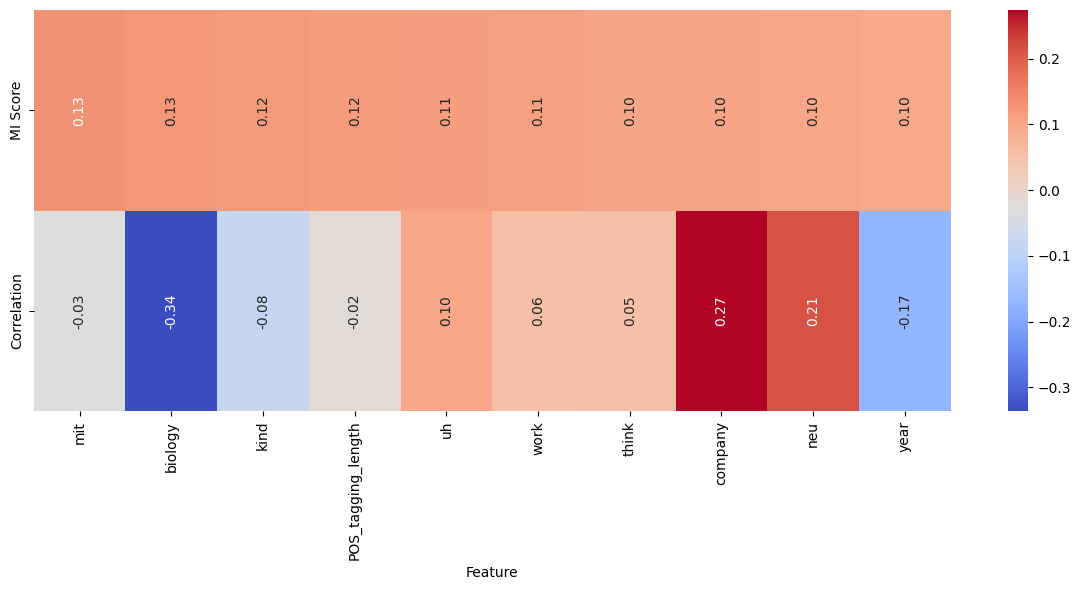


Top 10 correlation features for:  Overall


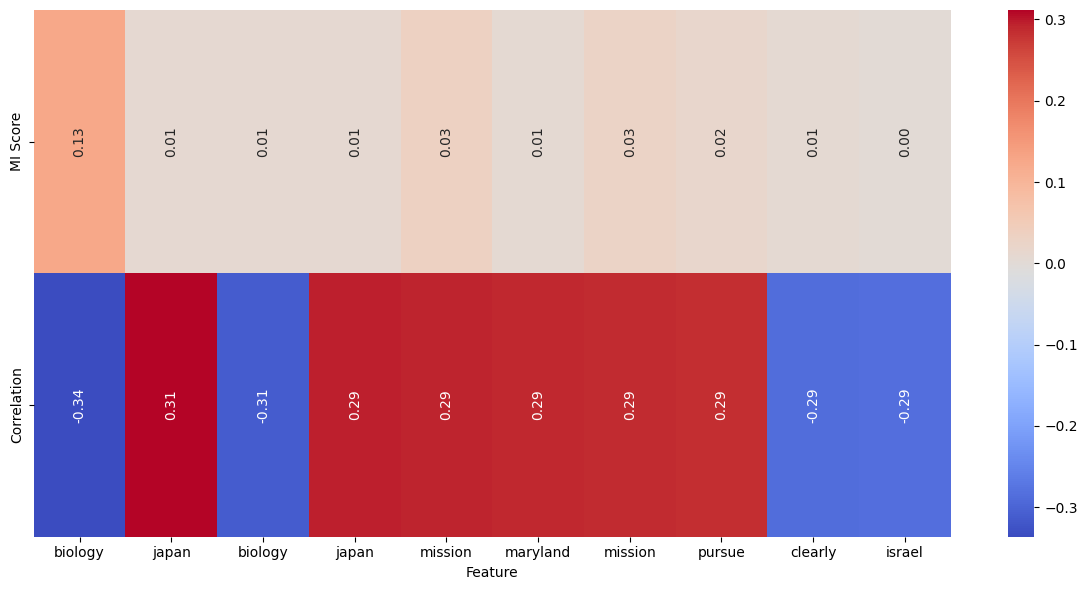


Top 10 mi features for:  Excited


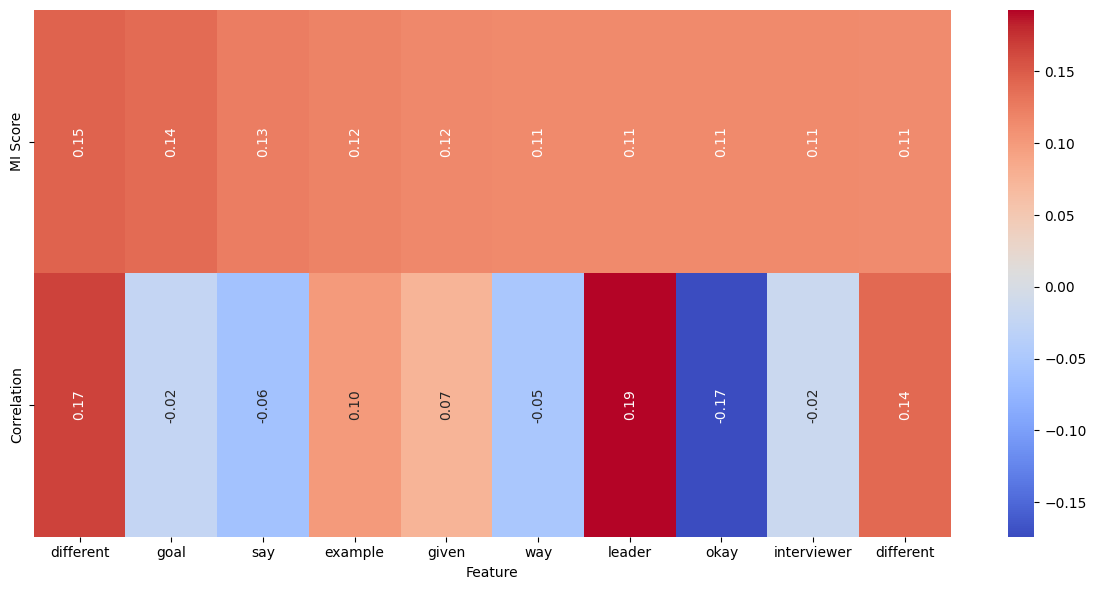


Top 10 correlation features for:  Excited


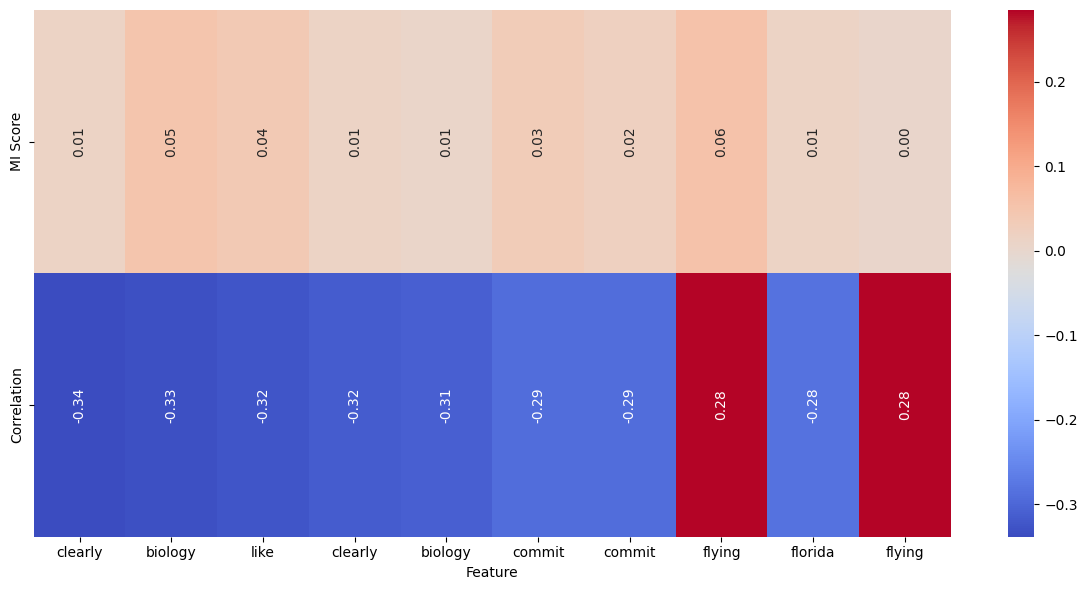

In [43]:
# Lets do a more human readable version of this (since word embedding isn't very human readable)

# Combine all features in to a single matrix X
X = np.hstack([X_dense, tfidf_matrix.toarray(), 
    features['word count'].values.reshape(-1, 1),
    features['avg word length'].values.reshape(-1, 1),
    features['pos tagging'].apply(len).values.reshape(-1, 1),
    sentiment_df['neg'].values.reshape(-1, 1),
    sentiment_df['neu'].values.reshape(-1, 1),
    sentiment_df['pos'].values.reshape(-1, 1),
    sentiment_df['compound'].values.reshape(-1, 1)
])

feature_names = (
    feature_names_count.tolist() + 
    feature_names_tf.tolist() + 
    ["word_count"] + 
    ["avg_word_length"] +
    ['POS_tagging_length'] +
    ["neg"] + ["neu"] + ['pos'] + ['compound']
)

get_top_10(X, feature_names)

##### Discussion - Overall outcome
Without the word embeddings, it becomes easier to see what human readable features are important. For example, Parts of Speech tagging becomes important (slight negative correlation) in mutual information. We also continue to see this pattern of certain words being helpful (such as biology being negatively correlated and company being positively correlated). For the best correlation values, these numbers are not a surprise because they show up on many of the other splitting mechanisms.

##### Discussion - Excited outcome
Without the word embeddings for the excited outcome, almost all of the highest outcomes are associated with singular words. These have also been the same words that we have been seeing through the various other methods of filtering features.

##### Actionable insight to the user
Looking at these outcomes, a user could take action on some of the insights by using more of the language that is positively associated with the 2 outcomes (overall and excited). A great example of this would be to look at the words that have the most negative correlation to performance and to try to avoid these words in an interview. Additionally, from the study paper, they extracted interesting features that had high correlation with positive outcomes such as using words like 'we' more than 'I', and using less filler words throughout the interview.

# (c) Estimating interview outcomes based on language

In [203]:
random_state = 30
np.random.seed(random_state)
tf.random.set_seed(random_state)

#### One Hidden Layer DL Model

In [204]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [205]:
# Deep learning function for part (c)
def create_deep_learning_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))  # Hidden layer with 128 neurons and ReLU activation
    model.add(Dense(64, activation='relu'))  # Another hidden layer with 64 neurons
    model.add(Dense(1))  # Output layer with 1 neuron for regression (predicting the score)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Adam optimizer and MSE loss
    return model

In [206]:
# Calculate Pearson's correlation (r)
def pearson_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]

In [207]:
# Calculate Absolute Relative Error (RE)
def absolute_relative_error(y_true, y_pred):
    return np.abs(y_true - y_pred) / np.max(y_true)

In [208]:
# Using features from part (b)
X = np.hstack([X_dense, tfidf_matrix.toarray(),
    features['word count'].values.reshape(-1, 1),
    features['avg word length'].values.reshape(-1, 1),
    features['pos tagging'].apply(len).values.reshape(-1, 1),
    sentiment_df['neg'].values.reshape(-1, 1),
    sentiment_df['neu'].values.reshape(-1, 1),
    sentiment_df['pos'].values.reshape(-1, 1),
    sentiment_df['compound'].values.reshape(-1, 1)
])

# Need to normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [209]:
X

array([[1.    , 0.    , 0.    , ..., 0.859 , 0.128 , 0.9955],
       [0.    , 0.    , 0.    , ..., 0.852 , 0.122 , 0.9988],
       [0.    , 0.    , 0.    , ..., 0.874 , 0.105 , 0.9966],
       ...,
       [1.    , 0.    , 0.    , ..., 0.764 , 0.219 , 0.9998],
       [0.    , 0.    , 0.    , ..., 0.779 , 0.186 , 0.9996],
       [0.    , 0.    , 0.    , ..., 0.811 , 0.174 , 0.9997]])

In [210]:
X_scaled

array([[ 8.24621125, -0.20050188, -0.1490712 , ...,  1.00748171,
        -0.67245067, -0.01371221],
       [-0.12126781, -0.20050188, -0.1490712 , ...,  0.82533173,
        -0.83905425,  0.16995077],
       [-0.12126781, -0.20050188, -0.1490712 , ...,  1.39780309,
        -1.31109772,  0.04750878],
       ...,
       [ 8.24621125, -0.20050188, -0.1490712 , ..., -1.46455371,
         1.85437025,  0.22560621],
       [-0.12126781, -0.20050188, -0.1490712 , ..., -1.07423233,
         0.93805058,  0.21447512],
       [-0.12126781, -0.20050188, -0.1490712 , ..., -0.24154671,
         0.60484342,  0.22004067]])

In [211]:
# Need to define the outcomes
y_overall = scores_data['Overall'].values
y_excited = scores_data['Excited'].values

# Splitting the data
X_train, X_test, y_train_overall, y_test_overall, y_train_excited, y_test_excited = train_test_split(X_scaled, y_overall, y_excited, test_size=0.2, random_state=random_state)

In [212]:
# Training model
model_overall = create_deep_learning_model(X_train.shape[1])
model_excited = create_deep_learning_model(X_train.shape[1])
model_overall.fit(X_train, y_train_overall, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
model_excited.fit(X_train, y_train_excited, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50


/Users/jasdeepsingh/tensorflow_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 32.5968 - mae: 5.5731 - val_loss: 38.3702 - val_mae: 5.8966
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.5378 - mae: 1.2295 - val_loss: 42.9257 - val_mae: 6.0882
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.8542 - mae: 1.8518 - val_loss: 45.7577 - val_mae: 6.2009
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.6654 - mae: 1.1365 - val_loss: 47.9133 - val_mae: 6.3174
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7677 - mae: 0.7147 - val_loss: 48.6355 - val_mae: 6.3745
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.8820 - mae: 0.8108 - val_loss: 48.3244 - val_mae: 6.3550
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5542 - mae: 0.6541 - val_loss: 47.5659 - val_mae: 6.2963
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3371 - mae: 0.4756 - val_loss: 47.2038 - val_mae: 6.2579
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2929 - mae: 0.4221 - v

In [213]:
# Making predictions
y_pred_overall = model_overall.predict(X_test)
y_pred_excited = model_excited.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [214]:
# Evaluating the models:

# Flatten the predicted values to 1D arrays
y_pred_overall = y_pred_overall.flatten()
y_pred_excited = y_pred_excited.flatten()

# Evaluate Pearson's correlation (r)
r_overall = pearson_corr(y_test_overall, y_pred_overall)
r_excited = pearson_corr(y_test_excited, y_pred_excited)

# Calculate Absolute Relative Error (RE)
re_overall = absolute_relative_error(y_test_overall, y_pred_overall).mean()
re_excited = absolute_relative_error(y_test_excited, y_pred_excited).mean()

print("Pearson's Correlation for Overall: " + str(r_overall))
print("Pearson's Correlation for Excited: " + str(r_excited))
print("Absolute Relative Error for Overall: " + str(re_overall))
print("Absolute Relative Error for Excited: " + str(re_excited))

Pearson's Correlation for Overall: -0.15187277866700744
Pearson's Correlation for Excited: -0.22324632441350284
Absolute Relative Error for Overall: 0.8103806229773554
Absolute Relative Error for Excited: 0.8635378683456095


The Pearson's Correlation for Overall and Excited show a weak negative between the predicted and actual overall performance scores. The simple one hidden layer is not able to predict with a high accuracy since the correlation is closer to 0 than the absolute value of 1. The negative value suggests an inverse relationship however not much can be said.

The Absolute Relative Error for Overall and Excited are 81.03% and 86.35% respectively. These are significant errors and show that the model did not perform well. This suggests even higher inaccuracy when coupled with the Pearson's Correlation.

#### Multi-Layer Perceptron Model

In [235]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [236]:
def build_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))  # First hidden layer with 128 units
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Dense(64, activation='relu'))  # Second hidden layer with 64 units
    model.add(Dropout(0.2))  # Another dropout layer
    model.add(Dense(1, activation='linear'))  # Output layer (linear activation for regression)
    
    # Compile the model with Adam optimizer and mean squared error loss for regression
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    
    return model

In [237]:
# Need to normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [238]:
# Build and train model
mlp_model_overall = build_mlp_model(X_train_scaled.shape[1])
mlp_model_overall.fit(X_train_scaled, y_train_overall, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


/Users/jasdeepsingh/tensorflow_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 26.0038 - mae: 4.9304 - val_loss: 32.5927 - val_mae: 5.3643
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.1837 - mae: 1.4870 - val_loss: 37.6751 - val_mae: 5.5431
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 8.4518 - mae: 2.2159 - val_loss: 40.3650 - val_mae: 5.7123
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 6.0055 - mae: 1.9967 - val_loss: 42.7641 - val_mae: 5.9203
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.8143 - mae: 1.6504 - val_loss: 45.0304 - val_mae: 6.1167
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.9386 - mae: 1.5280 - val_loss: 46.5805 - val_mae: 6.2348
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4.6751 - mae: 1.7422 - val_loss: 46.5360 - val_mae: 6.2306
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.5370 - mae: 1.7359 - val_loss: 45.0356 - val_mae: 6.1137
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4510 - mae: 1.

In [239]:
# Predict the outcomes on test set
y_pred_overall = mlp_model_overall.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [240]:
# Evaluating the model for Overall
y_pred_overall = y_pred_overall.flatten()
r_overall = pearson_corr(y_test_overall, y_pred_overall)  # Pearson's correlation
re_overall = absolute_relative_error(y_test_overall, y_pred_overall).mean()  # Absolute relative error

We can now do the same for "Excited"

In [241]:
# Build and train model
mlp_model_excited = build_mlp_model(X_train_scaled.shape[1])
mlp_model_excited.fit(X_train_scaled, y_train_excited, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 22.2030 - mae: 4.4106 - val_loss: 32.3935 - val_mae: 5.1722
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.7515 - mae: 1.7694 - val_loss: 39.4140 - val_mae: 5.5227
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 5.9019 - mae: 1.8117 - val_loss: 41.5373 - val_mae: 5.6308
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.8688 - mae: 1.8068 - val_loss: 42.0081 - val_mae: 5.6926
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 5.6524 - mae: 1.6912 - val_loss: 42.9445 - val_mae: 5.7766
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.8785 - mae: 1.3405 - val_loss: 42.6259 - val_mae: 5.7756
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.0372 - mae: 1.7013 - val_loss: 41.6228 - val_mae: 5.7228
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.7490 - mae: 1.7085 - val_loss: 41.1338 - val_mae: 5.7063
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.52

In [242]:
# Predict the outcomes on test set
y_pred_excited = mlp_model_excited.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [243]:
# Evaluating the model for Excited
y_pred_excited = y_pred_excited.flatten()
r_excited = pearson_corr(y_test_excited, y_pred_excited)  # Pearson's correlation
re_excited = absolute_relative_error(y_test_excited, y_pred_excited).mean() # Absolute relative error

In [244]:
print("Pearson's Correlation for Overall: " + str(r_overall))
print("Pearson's Correlation for Excited: " + str(r_excited))
print("Absolute Relative Error for Overall: " + str(re_overall))
print("Absolute Relative Error for Excited: " + str(re_excited))

Pearson's Correlation for Overall: 0.026239586851820124
Pearson's Correlation for Excited: -0.04030607051218055
Absolute Relative Error for Overall: 0.32662874809487524
Absolute Relative Error for Excited: 0.32216656444061564


The Pearson's Correlation for both Overall and Excited both close to 0 shows that there is almost no correlation between the predicted and true values. This suggests that the model is not capturing meaningful relationships in the data and that a different type of ML model such as RNN or LSTM or Tree based model needs to be implemented.

However the Absolute relative error has improved when compared to the simple one hidden layer perceptron model.

I dont think either of these models are acceptable for real world applications. Possibly using an RNN or LSTM would improve the accuracy and decrease the error hence using those models in the real world may be acceptable however the simple one hidden layer perceptron and multi-layer perceptron model would not be used in the real world. The computational cost for these models in this small environment is quite low hoever if extended to large amounts of data then faster processing units such as faster GPU's will be required to deploy these models.

# (d) Multimodal ML models

# (e) Explainable ML